In [1]:
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel
import torch, torchvision
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import math
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
def load_sentiment_data(sentiment_filename):
    sentiment_data = pd.DataFrame(columns=['id','sentence','sentiment'])
    rows=[]
    with open(sentiment_filename, 'r') as fp:
        for record in csv.DictReader(fp,delimiter = '\t'):
            sent = record['sentence'].lower().strip()
            sent_id = record['id'].lower().strip()
            sentiment = int(record['sentiment'].strip())
            if sentiment==1:
                sentiment=0 # both negative and very negative is mapped to negative
            elif sentiment==2:
                sentiment=1
            elif sentiment ==3 or sentiment==4:
                sentiment=2
            
            rows.append({'id': sent_id, 'sentence': sent, 'sentiment': sentiment})
        sentiment_data = pd.concat([sentiment_data, pd.DataFrame(rows)], ignore_index=True)
        sentiment_data['sentiment']=sentiment_data['sentiment'].astype('int')
        return sentiment_data  

In [4]:
class LoadDatasetLLM(Dataset):
    def __init__(self, tokens, labels):
        self.input_ids = tokens['input_ids']
        self.attention_mask = tokens['attention_mask']
        self.labels = torch.tensor(labels.values)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [5]:
def train(model, optimizer, train_loader, criterion):
    model.train()
    total_loss = 0
    total_acc = 0
    num_samples= 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs, dim=1)
        total_acc += (predictions == labels).sum().item()
        num_samples += labels.size(0)
        loss = criterion(outputs, labels)/16
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        torch.cuda.empty_cache()
        total_loss += loss.item()
    
    print(f'Training loss: {total_loss/len(train_loader)}, Training Acc:{total_acc/num_samples*100}%' )


In [6]:
def evaluate(model, test_loader):
    model.eval()
    total_loss = 0
    total_acc = 0
    num_samples=0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)  
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            total_acc += (predictions == labels).sum().item()
            num_samples += labels.size(0)

    print(f'Test acc: {total_acc/num_samples*100}%')

In [7]:
def show_metrics(model, data_loader):
    model.eval()
    total_acc = 0
    num_samples=0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)  
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            total_acc += (predictions == labels).sum().item()
            num_samples += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
           

    print(f'Accuracy: {total_acc/num_samples*100}%')
    cm = confusion_matrix(all_labels, all_predictions)
    class_names = ['Negative', 'Neural', 'Positive']
    cm = confusion_matrix(all_labels, all_predictions, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot() 
    plt.show()
    class_report = classification_report(all_labels, all_predictions, target_names=class_names)
    print("\nClassification Report:")
    print(class_report)

In [8]:
def see_predictions(model, test_data):
    model.eval()
    predictions = []

    with torch.no_grad():
        for index, row in test_data.iterrows():
            input_ids = tokenizer.encode(row['sentence'], add_special_tokens=True, max_length=128, truncation=True, return_tensors='pt')
            attention_mask = torch.ones_like(input_ids)
            input_ids, attention_mask=input_ids.to(device), attention_mask.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predicted_label = torch.argmax(outputs, dim=1).item()
            
            predictions.append({
                'sentence': row['sentence'],
                'true_label': row['sentiment'],
                'predicted_label': predicted_label
            })
    
    return predictions


In [9]:
class SentimentAnalysisModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(SentimentAnalysisModel, self).__init__()
        if model_name=='bert-base-uncased':
            self.bert = BertModel.from_pretrained(model_name)
        elif model_name=='roberta-base':
            self.bert = RobertaModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(self.bert.config.hidden_size, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1] 
        output = self.drop(pooled_output)
        return self.classifier(output)

In [ ]:
class MultitaskBERT(nn.Module):
    def __init__(self, model_name, num_labels_sentiment, num_labels_sarcasm ):
        super(MultitaskBERT, self).__init__()
        if model_name=='bert-base-uncased':
            self.bert = BertModel.from_pretrained(model_name)
        elif model_name='roberta-base':
            self.bert = RobertaModel.from_pretrained(model_name)
            
        self.sentiment_fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.sentiment_relu =  nn.ReLU()
        self.sentiment_dropout = nn.Dropout(dropout_prob)
        self.sentiment_proj = nn.Linear(self.bert.config.hidden_size, num_labels_sentiment)

        self.sarcasm_fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.sarcasm_relu =  nn.ReLU()
        self.sarcasm_dropout = nn.Dropout(dropout_prob)
        self.sarcasm_proj = nn.Linear(self.bert.config.hidden_size, num_labels_sarcasm)
        
    
        
    def process_sentiment_batch(batch, objects_group: ObjectsGroup, args: dict):
    '''This function processes a batch of SST data. It takes as input a batch of data, a group of objects (model, optimizer, scheduler, etc.), 
    and the arguments. It returns the loss of the batch.'''
    device = args.device
    model, scaler = objects_group.model, objects_group.scaler

    with autocast() if args.use_amp else nullcontext():
        b_ids, b_mask, b_labels = (batch['token_ids'], batch['attention_mask'], batch['labels'])
        b_ids, b_mask, b_labels = b_ids.to(device), b_mask.to(device), b_labels.to(device)

        embeddings = model.forward(b_ids, b_mask, task_id=0)
        logits = model.last_layers_sentiment(embeddings)
        
        loss = F.cross_entropy(logits, b_labels.view(-1), reduction='sum') / args.batch_size
        loss_value = loss.item()
        
        #To use smart_regularization
        if args.use_smart_regularization:
            smart_regularization(loss_value, args.smart_weight_regularization, embeddings, logits, model.last_layers_sentiment)

        objects_group.loss_sum += loss_value

        if args.projection == "none":
            if args.use_amp: scaler.scale(loss).backward()
            else: loss.backward()
        return loss
        

# Sentiment Analysis with Bert base model

In [10]:
sst_train_df=load_sentiment_data("./Dataset/Sentiment SST5/train.csv")
sst_test_df=load_sentiment_data("./Dataset/Sentiment SST5/test.csv")

<Axes: xlabel='sentiment', ylabel='count'>

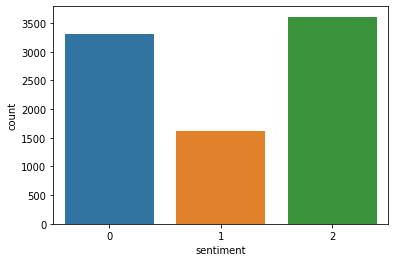

In [11]:
sns.countplot(sst_train_df['sentiment'])

<Axes: xlabel='sentiment', ylabel='count'>

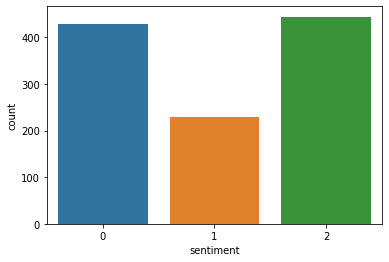

In [12]:
sns.countplot(sst_test_df['sentiment'])

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_length = tokenizer.model_max_length
train_tokens = tokenizer(sst_train_df['sentence'].to_list(), padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')
test_tokens = tokenizer(sst_test_df['sentence'].to_list(), padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')

train_set = LoadDatasetLLM(train_tokens, sst_train_df['sentiment'])
test_set = LoadDatasetLLM(test_tokens, sst_test_df['sentiment'])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16)

In [14]:
bert_model=SentimentAnalysisModel('bert-base-uncased',3)
bert_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-5)

In [15]:
for epoch in range(10):
    train(bert_model, optimizer, train_loader, criterion)
    evaluate(bert_model, test_loader)

100%|██████████| 534/534 [10:17<00:00,  1.16s/it]


Training loss: 0.0465924527970481, Training Acc:68.60955056179775%


100%|██████████| 69/69 [00:23<00:00,  2.94it/s]


Test acc: 72.11625794732062%


  6%|▌         | 32/534 [00:37<09:55,  1.19s/it]


KeyboardInterrupt: 

100%|██████████| 35/35 [00:24<00:00,  1.42it/s]

Accuracy: 70.57220708446866%


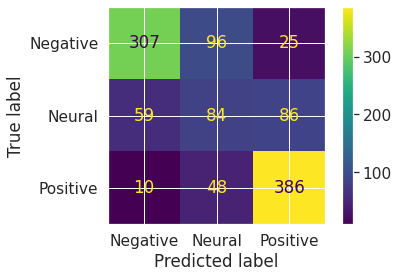


Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.72      0.76       428
      Neural       0.37      0.37      0.37       229
    Positive       0.78      0.87      0.82       444

    accuracy                           0.71      1101
   macro avg       0.65      0.65      0.65      1101
weighted avg       0.71      0.71      0.70      1101



In [44]:
show_metrics(bert_model, test_loader)

In [46]:
predictions = see_predictions(bert_model, sst_test_df)
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(f"/home/rsadhu/private/Analysis/results/sst_test_output_bert.csv")

# Sentiment Analysis with Roberta

In [48]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

max_length = tokenizer.model_max_length
train_tokens = tokenizer(sst_train_df['sentence'].to_list(), padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')
test_tokens = tokenizer(sst_test_df['sentence'].to_list(), padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')

train_set = LoadDatasetLLM(train_tokens, sst_train_df['sentiment'])
test_set = LoadDatasetLLM(test_tokens, sst_test_df['sentiment'])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

roberta_model=SentimentAnalysisModel('roberta-base',3)
roberta_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(roberta_model.parameters(), lr=2e-5)

for epoch in range(10):
    train(roberta_model, optimizer, train_loader, criterion)
    evaluate(roberta_model, test_loader)

KeyboardInterrupt: 

In [ ]:
show_metrics(roberta_model, test_loader)

In [ ]:
predictions = see_predictions(model, sst_test_df)
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(f"sst_test_output_roberta.csv")

# Multitask Learning

In [58]:
def train(args, config):
    
    device = torch.device('cuda') if args.use_gpu else torch.device('cpu')

    sentiment_train_data, neg_train_data, sar_train_data, sim_train_data = load_multitask_data()
    sentiment_test_data, neg_test_data, sar_test_data, sim_test_data = load_multitask_data(split ='test')

    # sentiment: Sentiment classification
    sentiment_train_data = SingleSentenceDataset(sentiment_train_data, args)
    sentiment_test_data = SingleSentenceDataset(sentiment_test_data, tokenizer=model_name)
    sentiment_train_dataloader = DataLoader(sentiment_train_data, shuffle=True, batch_size=config.batch_size_sst,
                                      collate_fn=sentiment_train_data.collate_fn)
    sentiment_test_dataloader = DataLoader(sentiment_test_data, shuffle=False, batch_size=config.batch_size_sst,
                                    collate_fn=sentiment_test_data.collate_fn)

    # sar: Sarcasm Classification
    sar_train_data = SingleSentenceDataset(sar_train_data, tokenizer=model_name)
    sar_test_data = SingleSentenceDataset(sar_test_data, tokenizer=model_name)
    sar_train_dataloader = DataLoader(sar_train_data, shuffle=True, batch_size=config.batch_size_para,
                                      collate_fn=para_train_data.collate_fn)
    sar_test_dataloader = DataLoader(sar_test_data, shuffle=False, batch_size=config.batch_size_para,
                                    collate_fn=sar_test_data.collate_fn)
    
    
    # neg: Negation Detection
    neg_train_data = PairSentenceDataset(neg_train_data, tokenizer=model_name)
    neg_test_data = PairSentenceDataset(neg_test_data, tokenizer=model_name)
    neg_train_dataloader = DataLoader(neg_train_data, shuffle=True, batch_size=config.batch_size_sts,
                                        collate_fn=neg_train_data.collate_fn)
    neg_test_dataloader = DataLoader(neg_test_data, shuffle=False, batch_size=config.batch_size_sts,
                                    collate_fn=neg_test_data.collate_fn)
    
    # sim: Semantic textual similarity
    sim_train_data = PairSentenceDataset(sim_train_data, , tokenizer=model_name, isRegression=True)
    sim_test_data = PairSentenceDataset(sim_test_data, tokenizer=model_name, isRegression=True)
    sim_train_dataloader = DataLoader(sim_train_data, shuffle=True, batch_size=config.batch_size_sts,
                                        collate_fn=sim_train_data.collate_fn)
    sim_test_dataloader = DataLoader(sim_test_data, shuffle=False, batch_size=config.batch_size_sts,
                                    collate_fn=sim_test_data.collate_fn)
    
    model= MultiTaskSentimentAnalysis(args, config)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=2e-5)
    scaler = GradScaler() 
    objects_group = ObjectsGroup(model, optimizer, scaler)
    
    if args.checkpoint:
        checkpoint=torch.load(args.checkpoint, map_location=device)
        new_state_dict = {}
        for key, value in checkpoint['model'].items():
            new_key = key.replace("_orig_mod.", "")
            new_state_dict[new_key] = value
        model.load_state_dict(new_state_dict)
        optimizer.load_state_dict(checkpoint['optimizer'])
        
                                  
    
    best_test_metric = 0
    best_test_metrics = {'sentiment': 0, 'sar': 0, 'neg': 0, 'sim': 0}
    
    dataloaders = {'sentiment': sentiment_train_dataloader, 'sar': sar_train_dataloader, 'neg': neg_train_dataloader, 'sim': sim_train_dataloader}
    
    scheduler = None
    
    if args.task== 'multi':
        scheduler = RoundRobinScheduler(dataloaders)
        
        with open(f'./logs/logs_multitask.txt', "w") as f:
                f.write(f"Epoch,Training Loss sentiment, Training Loss sarcasm, Training Loss negation,\
                Training Loss similarity, Test Accuracy Sentiment, Test Accuracy sarcasm,\
                Test Accuracy negation, Test R2 similarity\n")
        
    elif args.task in ['sentiment', 'neg', 'sar', 'sim']:
        # If we are using a single task, we don't need a scheduler
        scheduler = RandomScheduler(dataloaders)
        task = args.task
        n_batches = 0
        best_test_metric = -np.inf
        
        with open(f'logs_{task}.txt', "w") as f:
            if task=='sim':
                f.write(f"Epoch,Training Loss, Test r2\n")
            else:
                f.write(f"Epoch,Training Loss, Test Acc\n")

        for epoch in range(args.epochs):
            model.train()
            for i in tqdm(range(args.num_batches_per_epoch)):
                loss = scheduler.process_named_batch(objects_group, args, name=task)
                n_batches += 1
                if not args.no_tensorboard:
                    writer.add_scalar("Loss " + task, loss.item(), args.batch_size * n_batches)
                    writer.add_scalar("Specific Loss " + task, loss.item(), args.batch_size * n_batches)

            # Evaluate on dev set
            test_metric = 0
            if task == 'sentiment': test_metric = model_eval_sentiment(sentiment_test_dataloader, model, device)
            elif task == 'neg': test_metric = model_eval_negation(neg_test_dataloader, model, device)
            elif task == 'sar': test_metric = model_eval_sarcasm(sar_test_dataloader, model, device)
            elif task=='sim': test_metric = model_eval_similarity(sim_test_dataloader, model, device)
                
            with open(f'logs_{task}.txt',, "a") as f:
                f.write(f"{epoch},{loss},{test_metric}\n")

            if test_metric > best_test_metric:
                best_test_metric = test_metric
                saved_path = save_model(model, optimizer, args, config, args.filepath)

        return
    
    else:
        print("Task Not Valid.")
        print("Task should be either muklitask, sentiment, neg, sar or sim!")
        return
    
    
    
    for epoch in range(args.epochs):
        model.train()
        train_loss = {'sentiment': 0, 'sar': 0, 'neg': 0, 'sim': 0}
        num_batches = {'sentiment': 0, 'sar': 0, 'neg': 0, 'sim': 0}
        for i in tqdm(range(num_batches_per_epoch)):
            
                task, loss = scheduler.process_one_batch(objects_group=objects_group, args=args)
                n_batches += 1
                train_loss[task] += loss.item()
                num_batches[task] += 1
                total_num_batches[task] += 1
        
                    
        (sentiment_accuracy, 
         negation_accuracy, 
         sarcasm_accuracy, 
         similarity_r2) = model_eval_multitask(sentiment_test_dataloader, neg_test_dataloader, sar_test_dataloader, sim_train_dataloader, model, device, args)
        
        with open(f'./logs/logs_multitask.txt', "a") as f:
                f.write(f"{epoch},{train_loss['sentiment']}, {train_loss['sar']}, {train_loss['neg']},\
                {train_loss['sim']}, {sentiment_accuracy}, {sarcasm_accuracy},\
                {negation_accuracy}, {similarity_r2}\n")
                
     
        
        
    

In [74]:
train_similarity.head()

,id,sentence1,sentence2,similarity
0,6d0ec4e8a34ac432e1c1699a0,13 killed in Afgan terror attack,6 killed in Afghan capital mosque attack,2.0
1,9aaabdce8cfff4c060b6f525c,China to resume US investment talks,China and Taiwan hold historic talks,0.8
2,a70c8ad3f82ac2967f78fe617,But in the first 30 seconds after Young entere...,"But in the first 30 seconds of the bout, famil...",4.2
3,a89ed469c8f2f81313d190e66,A yellow vested person is doing road work.,A person is doing very well on their skateboard.,0.2
4,9ee4d44188c33f4e7d899e690,Someone is slicing tortila's.,Someone is riding a horse.,0.0


0.0

In [33]:

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 for binary classification
model.to(device)

# Load the test data from a Pandas DataFrame
# Assuming test_df is already defined and contains 'headline' and 'is_sarcastic' columns

# Encode the input headlines using batch encoding
headlines = test_df['headline'].tolist()
max_length = tokenizer.model_max_length
encoded_inputs = tokenizer(headlines, padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')

# Create a TensorDataset
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']
dataset = TensorDataset(input_ids, attention_masks)

# Create a DataLoader
batch_size = 64  # Adjust this value based on your GPU memory
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4)  # num_workers can be adjusted based on your CPU cores

# Get the true labels from the DataFrame
true_labels = test_df['is_sarcastic'].tolist()

# Classify the headlines and store the predictions
model.eval()
predictions = []
for batch in tqdm(dataloader):
    input_ids, attention_masks = batch
    input_ids, attention_masks = input_ids.to(device), attention_masks.to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        predicted_classes = logits.argmax(dim=1)
        predictions.extend(predicted_classes.cpu().tolist())

print("Done")

# Calculate the test accuracy
correct = sum(pred == true_label for pred, true_label in zip(predictions, true_labels))
test_accuracy = correct / len(true_labels)

print(f"Test accuracy: {test_accuracy:.4f}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Done
Test accuracy: 0.4683


In [56]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_length = tokenizer.model_max_length  # Get the model's max length
train_tokens = tokenizer(train_df['headline'].to_list(), padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')
test_tokens = tokenizer(test_df['headline'].to_list(), padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')


train_set = HeadlineDataset(train_tokens, train_df['is_sarcastic'])
test_set = HeadlineDataset(test_tokens, test_df['is_sarcastic'])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # 2 for binary classification
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

def train(model, optimizer, train_loader, criterion):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        total_loss += loss.item()
    
    print(f'Training loss: {total_loss/len(train_loader)}')

def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)  
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            total_acc += (predictions == labels).sum().item()

    print(f'Test acc: {total_acc/len(test_set)*100}%')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
for epoch in range(3):
    train(model, optimizer, train_loader, criterion)
    evaluate(model, test_loader, criterion)

100%|██████████| 1789/1789 [32:38<00:00,  1.09s/it]


Training loss: 0.24563232670882232


100%|██████████| 1670/1670 [09:53<00:00,  2.81it/s]


Test acc: 96.46935489909768%


100%|██████████| 1789/1789 [32:38<00:00,  1.09s/it]


Training loss: 0.09645665558116212


100%|██████████| 1670/1670 [09:53<00:00,  2.82it/s]


Test acc: 99.42715938447714%


100%|██████████| 1789/1789 [32:35<00:00,  1.09s/it]


Training loss: 0.03951431114999385


100%|██████████| 1670/1670 [09:54<00:00,  2.81it/s]

Test acc: 99.81654124078027%


<Axes: xlabel='sentiment', ylabel='count'>

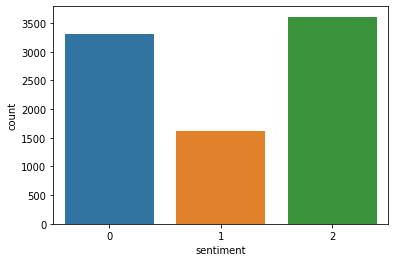

In [8]:
for epoch in range(5):
    train(model, optimizer, train_loader, criterion)
    evaluate(model, test_loader, criterion)

100%|██████████| 534/534 [09:47<00:00,  1.10s/it]


Training loss: 0.744674407280563, Training Acc:68.375468164794%


100%|██████████| 69/69 [00:24<00:00,  2.81it/s]


Test acc: 72.29791099000909%


100%|██████████| 534/534 [09:46<00:00,  1.10s/it]


Training loss: 0.5079166363464312, Training Acc:79.26029962546816%


100%|██████████| 69/69 [00:24<00:00,  2.81it/s]


Test acc: 73.38782924613987%


100%|██████████| 534/534 [09:46<00:00,  1.10s/it]


Training loss: 0.3417310155579325, Training Acc:86.92649812734082%


100%|██████████| 69/69 [00:24<00:00,  2.81it/s]


Test acc: 71.11716621253406%


100%|██████████| 534/534 [09:46<00:00,  1.10s/it]


Training loss: 0.24426931245705943, Training Acc:91.73689138576779%


100%|██████████| 69/69 [00:24<00:00,  2.81it/s]


Test acc: 70.6630336058129%


100%|██████████| 534/534 [09:46<00:00,  1.10s/it]


Training loss: 0.15770743773510673, Training Acc:94.74485018726591%


100%|██████████| 69/69 [00:24<00:00,  2.81it/s]

Test acc: 69.5731153496821%


In [85]:
import os
os.path.dirname(os.path.realpath("Script.ipynb"))

'/home/rsadhu/private/Analysis/Dataset'

In [86]:
pd.read_csv("/home/rsadhu/private/Analysis/Dataset/STS SemEval/sts-train.csv")

ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 7


In [9]:
import csv
def load_negation_data(negation_filename):
    negation_data=[]
                                  
    with open(negation_filename, 'r') as f:
        for row in csv.DictReader(f,delimiter = '\t'):
            sentence1 = row['premise'].lower().strip()
            sentence2= row['hypothesis'].lower().strip()
            negation_data.append((sentence1, sentence2, int(row['label'])))
    return negation_data

In [11]:
a=load_negation_data("./Dataset/cannot_dataset.tsv")

In [7]:
sen="I am a girl."
print(sen.lower().strip())

i am a girl.


In [12]:
a

[('the joint typhoon warning center (jtwc) also issued warnings in an unofficial capacity.',
  'the joint typhoon warning center (jtwc) only issued warnings in a capacity that was unofficial.',
  1),
 ('commercial dnp is used as an antiseptic and as a non-selective bioaccumulating pesticide.',
  'commercial dnp is unable to be utilized as an antiseptic or as a non-selective bioaccumulating pesticide.',
  1),
 ('spinal locks and cervical locks are allowed and mandatory in ibjjf brazilian jiu-jitsu competitions.',
  'spinal locks and cervical locks are forbidden in ibjjf brazilian jiu-jitsu competitions.',
  1),
 ('dredgers excavate the sediment using mechanical or hydraulic methods or a combination of both.',
  'the dredgers use either mechanical or hydraulic methods.',
  0),
 ('in 2014, nextgen earns klas top performance honors for ambulatory rcm services.',
  'in 2014, nextgen fails to achieve klas top performance honors for ambulatory rcm services.',
  1),
 ('on june 22, 2009, the se

In [34]:
import pandas as pd
def load_negation_data(negation_filename):
    negation_data=[]
                                  
    with open(negation_filename, 'r') as f:
        for row in csv.DictReader(f,delimiter = '\t'):
            sentence1 = row['premise'].lower().strip()
            sentence2= row['hypothesis'].lower().strip()
            negation_data.append((sentence1, sentence2,int(row['label'])))
    
    return negation_data

In [35]:
a=load_negation_data('./Dataset/Cannot_data/train.csv')
a

[('it is found in china.', 'it is found in china (tibet and yunnan).', 0),
 ('the 2012 napf bench press championships will be held in denver, co.',
  'moore was invited to compete in the 2012 napf bench press championships in denver, co.',
  0),
 ("in 2005, philp was listed as one of the uk's top 50 entrepreneurs by startups.co.uk.",
  "in 2005, philp was listed as one of the uk's top 50 entrepreneurs.",
  0),
 ('the structure of this film is easily the most tightly constructed in the history of cinema. 1',
  'the structure of this film is the most tightly constructed in the history of cinema.',
  0),
 ('he stayed in england until november 1918, when he again took up his ymca duties, establishing a rest hut and library in cologne.',
  'he stayed in england until november 1918, when he again took up his ymca duties, establishing a rest hut and library in italy.',
  1),
 ('herzenberg grew up and attended public school in oklahoma city.',
  'herzenberg grew up but failed to attend public 

In [30]:
train_df.to_csv('./Dataset/Cannot_data/train.csv', sep='\t', index=False)